# Problem Statement:Clustering and Visualization of Exoplanet Candidate Data from NASA’s Kepler Mission to Identify Natural Groupings Among Planetary Systems.

## Performed By-
| Sr. No | Name               | PRN          | Batch |
|--------|--------------------|-------------|-------|
| 1      | Sahil Awatramani  | 23070126112 | B2    |
| 2      | Soham Kulkarni    | 23070126129 | B2    |


# Dataset Description-

**Dataset Link** - https://www.kaggle.com/datasets/nasa/kepler-exoplanet-search-results?hl=en-IN

The dataset **cumulative.csv** contains astrophysical data related to exoplanet detection. The primary target variable is **'koi_disposition'**, which indicates whether a detected object is a confirmed exoplanet, false positive, or candidate. The dataset includes a mix of numerical and categorical features that describe planetary and stellar characteristics.

## Key Attributes:

- Target Variable: 'koi_disposition' (Categorical - Encoded as 0, 1, or 2)

- Numerical Features: Various astronomical measurements, including orbital properties, planetary radii, and stellar characteristics.

- Categorical Features: May include star classification details or detection method information.

**Data Summary:**

- Total Rows: 9564

- Total Columns: 50

- Missing Values: Several columns contain missing values, requiring imputation.

- Class Distribution: The dataset exhibits some imbalance among exoplanet classes, requiring attention during modeling.

In [2]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from prettytable import PrettyTable
import umap.umap_ as umap
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, Birch
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from scipy.cluster.hierarchy import dendrogram, linkage
import warnings
warnings.filterwarnings("ignore")

c:\Users\Victus\anaconda3\envs\uslp\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data Preprocessing

In this section, we prepared the Kepler exoplanet dataset for clustering by performing the following preprocessing steps:

1. **Data Loading**  
   - Loaded the dataset from the `cumulative.csv` file.

In [3]:
# Load and Clean Data
df = pd.read_csv("C:\\Users\\Victus\\OneDrive\\Desktop\\USL\\DR_Project\\data\\cumulative.csv")
# Data Shape
print("Data Shape:", df.shape)

Data Shape: (9564, 50)


2. **Column Dropping**  
   - Removed irrelevant columns like identifiers and names: `rowid`, `kepid`, `kepler_name`, and `kepoi_name`.

In [4]:
# Drop unnecessary columns
drop_cols = ['rowid', 'kepid', 'kepler_name', 'kepoi_name']
df.drop(columns=[col for col in drop_cols if col in df.columns], inplace=True)

3. **Feature Selection**  
   - Selected a subset of meaningful numerical and categorical features relevant for clustering:
     ```
     koi_disposition, koi_pdisposition, koi_period, koi_time0bk, koi_impact,
     koi_duration, koi_depth, koi_prad, koi_teq, koi_srad, koi_steff,
     koi_model_snr, koi_kepmag, koi_insol
     ```


In [5]:
# Meaningful numerical and categorical features
selected_features = [
    'koi_disposition', 'koi_pdisposition', 'koi_period', 'koi_time0bk',
    'koi_impact', 'koi_duration', 'koi_depth', 'koi_prad', 'koi_teq',
    'koi_srad', 'koi_steff', 'koi_model_snr', 'koi_kepmag', 'koi_insol'
]
df = df[selected_features]

4. **Missing Value Handling**  
   - Filled missing values in **numeric columns** with their respective **median** values.
   - Filled missing values in **categorical columns** with the **most frequent (mode)** value.

In [6]:
# Check for missing values
missing_values = df.isnull().sum()
print("Missing values in each column:\n", missing_values[missing_values > 0])


# Fill missing numeric columns with median
df.fillna(df.median(numeric_only=True), inplace=True)


Missing values in each column:
 koi_impact       363
koi_depth        363
koi_prad         363
koi_teq          363
koi_srad         363
koi_steff        363
koi_model_snr    363
koi_kepmag         1
koi_insol        321
dtype: int64


5. **Categorical Encoding**  
   - Encoded categorical variables `koi_disposition` and `koi_pdisposition` using `LabelEncoder`.

In [7]:
# Fill and encode categorical columns
for col in ['koi_disposition', 'koi_pdisposition']:
    df[col].fillna(df[col].mode()[0], inplace=True)
    df[col] = LabelEncoder().fit_transform(df[col])


6. **Feature Engineering**  
   - Created new derived features:
     - `planet_star_radius_ratio` = planet radius / star radius
     - `planet_star_temp_ratio` = planet temperature / star effective temperature
     - `insolation_normalized` = insolation flux / star effective temperature

In [8]:
# Feature engineering
df['planet_star_radius_ratio'] = df['koi_prad'] / df['koi_srad']
df['planet_star_temp_ratio'] = df['koi_teq'] / df['koi_steff']
df['insolation_normalized'] = df['koi_insol'] / df['koi_steff']

# Final features to be used
print(df.head())

   koi_disposition  koi_pdisposition  koi_period  koi_time0bk  koi_impact  \
0                1                 0    9.488036   170.538750       0.146   
1                1                 0   54.418383   162.513840       0.586   
2                2                 1   19.899140   175.850252       0.969   
3                2                 1    1.736952   170.307565       1.276   
4                1                 0    2.525592   171.595550       0.701   

   koi_duration  koi_depth  koi_prad  koi_teq  koi_srad  koi_steff  \
0       2.95750      615.8      2.26    793.0     0.927     5455.0   
1       4.50700      874.8      2.83    443.0     0.927     5455.0   
2       1.78220    10829.0     14.60    638.0     0.868     5853.0   
3       2.40641     8079.2     33.46   1395.0     0.791     5805.0   
4       1.65450      603.3      2.75   1406.0     1.046     6031.0   

   koi_model_snr  koi_kepmag  koi_insol  planet_star_radius_ratio  \
0           35.8      15.347      93.59        

7. **Feature Scaling**  
   - Standardized all numerical features using **`StandardScaler`** to bring them to the same scale, essential for clustering algorithms.

In [9]:
# Final feature set
features = df.select_dtypes(include=[np.number])
scaler = StandardScaler()
scaled_data = scaler.fit_transform(features)

# Exploratory Data Analysis (EDA)

## Feature Correlation Heatmap

- A **correlation heatmap** was created to explore linear relationships between the numerical features.
- The heatmap helps in identifying:
  - Highly correlated variables (positive or negative),
  - Potential redundancy in features,
  - Clustering-relevant patterns or dependencies in the dataset.
  
```python
sns.heatmap(correlation_matrix, cmap='coolwarm')
```

> **Insight:** Features like `koi_prad`, `koi_depth`, and `koi_duration` showed moderate to high correlations, which can affect distance-based clustering methods and dimensionality reduction.

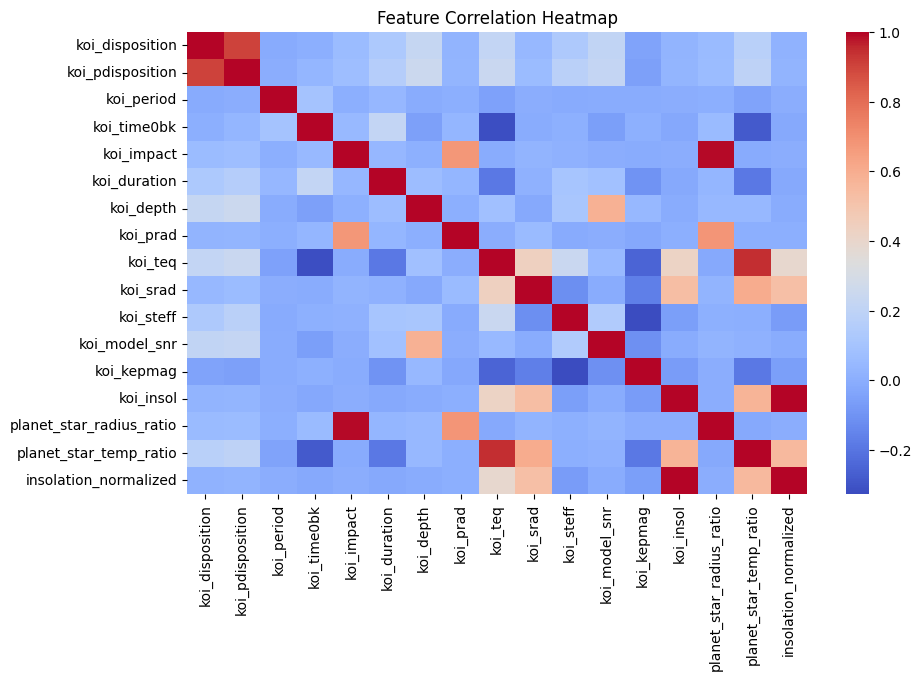

In [10]:
# EDA
plt.figure(figsize=(10, 6))
sns.heatmap(pd.DataFrame(scaled_data, columns=features.columns).corr(), cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

##  PCA: Explained Variance

- Principal Component Analysis (PCA) was applied to assess how much variance each component captures.
- A **cumulative explained variance plot** was generated to determine the optimal number of components to retain.

```python
plt.plot(np.cumsum(pca.explained_variance_ratio_))
```

> **Insight:** A small number of principal components (e.g., the first 5–6) can capture a large portion of the variance, indicating that **dimensionality reduction** can be applied without significant loss of information. This helps improve clustering performance and visualization clarity.

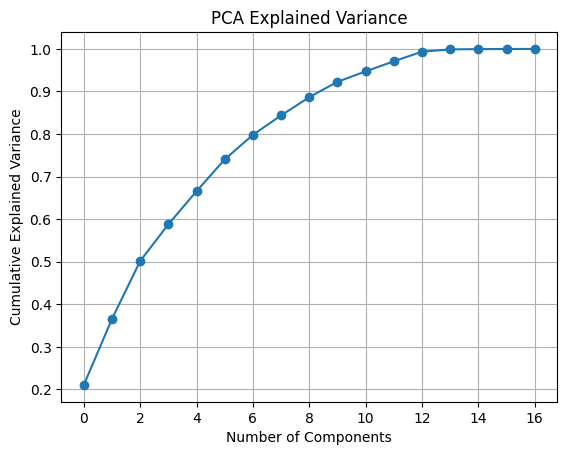

In [11]:
# PCA Variance Explained
pca_full = PCA().fit(scaled_data)
plt.plot(np.cumsum(pca_full.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.grid(True)
plt.show()

# Clustering Implementation with Performance Evaluation

To uncover natural groupings among planetary systems, we implemented and evaluated four clustering algorithms: **K-Means**, **Agglomerative Clustering**, **DBSCAN**, and **BIRCH**. Each algorithm was tuned using a systematic search over its hyperparameters, and the resulting cluster quality was assessed using multiple metrics.

## Algorithms Used:
- **K-Means Clustering**: Partitions the data into k distinct clusters by minimizing the within-cluster variance.
- **Agglomerative Clustering**: A hierarchical clustering method that merges the closest clusters iteratively.
- **DBSCAN (Density-Based Spatial Clustering of Applications with Noise)**: Groups together closely packed points and marks outliers as noise.
- **BIRCH (Balanced Iterative Reducing and Clustering using Hierarchies)**: Efficient for large datasets using CF trees and incremental clustering.

## Hyperparameter Tuning:
Each algorithm was optimized using **Grid Search** (or Random Search when needed) based on the **Silhouette Score**. The best hyperparameters were selected to maximize cluster cohesion and separation.

- **K-Means**: Tuned `n_clusters`, `init`, `n_init`, and `max_iter`
- **Agglomerative**: Tuned `n_clusters` and `linkage` method
- **DBSCAN**: Tuned `eps` and `min_samples`
- **BIRCH**: Tuned `threshold` and `branching_factor`

## Evaluation Metrics:
The following metrics were used to evaluate clustering performance:

- **Silhouette Score**: Measures how similar a point is to its own cluster vs other clusters. Higher values indicate better-defined clusters.
- **Calinski-Harabasz Index**: Ratio of between-cluster dispersion to within-cluster dispersion. Higher is better.
- **Davies-Bouldin Index**: Measures average similarity between clusters. Lower values indicate better separation.

In [12]:
# Clustering Algorithm Selection

# Algorithms dictionary
algorithms = {
    'KMeans': KMeans(random_state=42),
    'Agglomerative': AgglomerativeClustering(),
    'DBSCAN': DBSCAN(),
    'Birch': Birch()
}

# Parameter grids
kmeans_param_grid = {
    'n_clusters': [2, 3, 4, 5, 6, 7, 8, 9],
    'init': ['k-means++', 'random'],
    'n_init': [10, 20, 30],
    'max_iter': [100,300, 500]
}

agg_param_grid = {
    'n_clusters': [2, 3, 4, 5, 6, 7],
    'linkage': ['ward', 'complete', 'average', 'single']
}

dbscan_param_grid = {
    'eps': np.linspace(5.0, 10.0, 10),
    'min_samples': range(5, 15)
}

birch_param_grid = {
    'threshold': np.linspace(0.5, 2.0, 15),
    'branching_factor': [10, 20,25, 30,35,40, 50]
}

# Function to evaluate clustering models using multiple metrics
def evaluate_clustering_model(model, param_grid, data, search_method="grid"):
    def silhouette_scorer(estimator, X):
        labels = estimator.fit_predict(X)
        return silhouette_score(X, labels) if len(set(labels)) > 1 else -1

    if search_method == "grid":
        search = GridSearchCV(model, param_grid, cv=3, n_jobs=-1, verbose=1, refit=False, scoring=silhouette_scorer)
    else:
        search = RandomizedSearchCV(model, param_grid, n_iter=10, cv=3, n_jobs=-1, random_state=42, verbose=1, refit=False, scoring=silhouette_scorer)

    search.fit(data)
    best_params = search.best_params_

    if isinstance(model, KMeans):
        best_model = KMeans(**best_params, random_state=42)
    elif isinstance(model, AgglomerativeClustering):
        best_model = AgglomerativeClustering(**best_params)
    elif isinstance(model, DBSCAN):
        best_model = DBSCAN(**best_params)
    elif isinstance(model, Birch):
        best_model = Birch(**best_params)

    best_model.fit(data)
    labels = best_model.labels_ if hasattr(best_model, 'labels_') else best_model.fit_predict(data)

    silhouette = silhouette_score(data, labels) if len(set(labels)) > 1 else -1
    calinski = calinski_harabasz_score(data, labels) if len(set(labels)) > 1 else -1
    davies = davies_bouldin_score(data, labels) if len(set(labels)) > 1 else -1

    return best_model, labels, {
        'silhouette': silhouette,
        'calinski': calinski,
        'davies': davies,
        'best_params': best_params
    }

# Store results
cluster_results = {}

# Run evaluation for each model
for name, algo in algorithms.items():
    print(f"Tuning {name}...")
    
    if name == 'KMeans':
        best_model, labels, metrics = evaluate_clustering_model(algo, kmeans_param_grid, scaled_data)
    elif name == 'Agglomerative':
        best_model, labels, metrics = evaluate_clustering_model(algo, agg_param_grid, scaled_data)
    elif name == 'DBSCAN':
        best_model, labels, metrics = evaluate_clustering_model(algo, dbscan_param_grid, scaled_data)
    elif name == 'Birch':
        best_model, labels, metrics = evaluate_clustering_model(algo, birch_param_grid, scaled_data)

    cluster_results[name] = {
        'labels': labels,
        'silhouette': metrics['silhouette'],
        'calinski': metrics['calinski'],
        'davies': metrics['davies'],
        'best_params': metrics['best_params']
    }

    print(f"{name}  Best Params: {metrics['best_params']}")
    print(f"{name}  Silhouette Score: {metrics['silhouette']:.4f}")
    print(f"{name}  Calinski-Harabasz Index: {metrics['calinski']:.2f}")
    print(f"{name}  Davies-Bouldin Index: {metrics['davies']:.4f}")
    print("------------------------------------------------------")

Tuning KMeans...
Fitting 3 folds for each of 144 candidates, totalling 432 fits
KMeans  Best Params: {'init': 'k-means++', 'max_iter': 100, 'n_clusters': 2, 'n_init': 10}
KMeans  Silhouette Score: 0.9014
KMeans  Calinski-Harabasz Index: 1391.85
KMeans  Davies-Bouldin Index: 0.5424
------------------------------------------------------
Tuning Agglomerative...
Fitting 3 folds for each of 24 candidates, totalling 72 fits
Agglomerative  Best Params: {'linkage': 'average', 'n_clusters': 2}
Agglomerative  Silhouette Score: 0.9573
Agglomerative  Calinski-Harabasz Index: 593.20
Agglomerative  Davies-Bouldin Index: 0.0295
------------------------------------------------------
Tuning DBSCAN...
Fitting 3 folds for each of 100 candidates, totalling 300 fits
DBSCAN  Best Params: {'eps': np.float64(10.0), 'min_samples': 8}
DBSCAN  Silhouette Score: 0.8740
DBSCAN  Calinski-Harabasz Index: 853.07
DBSCAN  Davies-Bouldin Index: 1.4819
------------------------------------------------------
Tuning Birch..

# Evaluation Metrics Analysis:

| Algorithm     | Silhouette Score | Davies-Bouldin Index | Calinski-Harabasz Score | Hyperparameters                                             | Performance Summary                                                                                 |
|---------------|------------------|-----------------------|--------------------------|-------------------------------------------------------------|------------------------------------------------------------------------------------------------------|
| **KMeans**    | 0.9014           | 0.5424                | 1391.85                  | `n_clusters=2`, `init='k-means++'`, `max_iter=100`, `n_init=10` | Performed very well; formed compact, well-separated clusters with high CHI.                         |
| **DBSCAN**    | 0.8740           | 1.4819                | 853.07                   | `eps=10.0`, `min_samples=8`                                 | Handled noise well and detected arbitrary shapes; higher DBI indicates some overlapping clusters.   |
| **Agglomerative** | 0.9573       | 0.0295                | 593.2                    | `n_clusters=2`, `linkage='average'`                         | **Best overall performance** with highest Silhouette and lowest DBI; clusters are compact and distinct. |
| **BIRCH**     | 0.9019           | 0.4876                | 1402.09                  | `branching_factor=10`, `threshold=1.464`                    | Fast and scalable; performance close to KMeans with slightly better DBI and CHI.                    |


**Conclusion**: Based on overall evaluation metrics, **Agglomerative Clustering** performed the best — achieving the **highest Silhouette Score** and **lowest Davies-Bouldin Index**, indicating compact and well-separated clusters.

# Clustering Results and Analysis

In this section, we analyze and compare the performance of different clustering algorithms applied to the processed dataset. The clustering was aimed at discovering inherent groupings in exoplanet data based on planetary and stellar features.

## Dimensionality Reduction for Visualization

To enable intuitive visualization, the high-dimensional feature space was reduced to two principal components using **PCA (Principal Component Analysis)**. These 2D representations allowed us to observe the spatial distribution of clusters formed by each algorithm.

## Clustering Algorithms Compared

The following clustering techniques were applied:
- **KMeans**
- **DBSCAN**
- **Agglomerative Clustering**
- **Birch**

Each algorithm was tuned using essential hyperparameters and evaluated using internal clustering validation metrics.

## Evaluation Metrics Used

Three common metrics were used to evaluate the clustering quality:
- **Silhouette Score**: Measures cohesion vs. separation (higher is better).
- **Calinski-Harabasz Index**: Evaluates cluster dispersion (higher is better).
- **Davies-Bouldin Index**: Measures intra-cluster similarity (lower is better).

The clustering performance across algorithms was visualized using scatter plots (PCA-reduced) and a comparative bar plot of Silhouette scores.

## Comparative Performance Table

A tabular summary of all clustering algorithms with their respective evaluation metrics and hyperparameters was generated using **PrettyTable** for better readability. This comparison helped in selecting the most balanced and interpretable model.

## Model Selection and Profiling

Based on the scores and dendrogram analysis, **Agglomerative Clustering** was selected as the most suitable method. The clusters generated were further analyzed through profiling of feature means, enabling semantic labeling of clusters such as:

- Earth-like Planets
- Hot Rocky Planets
- Massive Gas Giants
- Close-Orbit Giants
- Bright Star Systems
- Standard Planetary Systems

These semantic labels were added back to the main dataset for better interpretability and downstream use.

## Additional Visualizations

- A **dendrogram** was plotted for Agglomerative Clustering to examine hierarchical relationships.
- A **bar chart** of Silhouette Scores across algorithms was generated to visually compare performance.

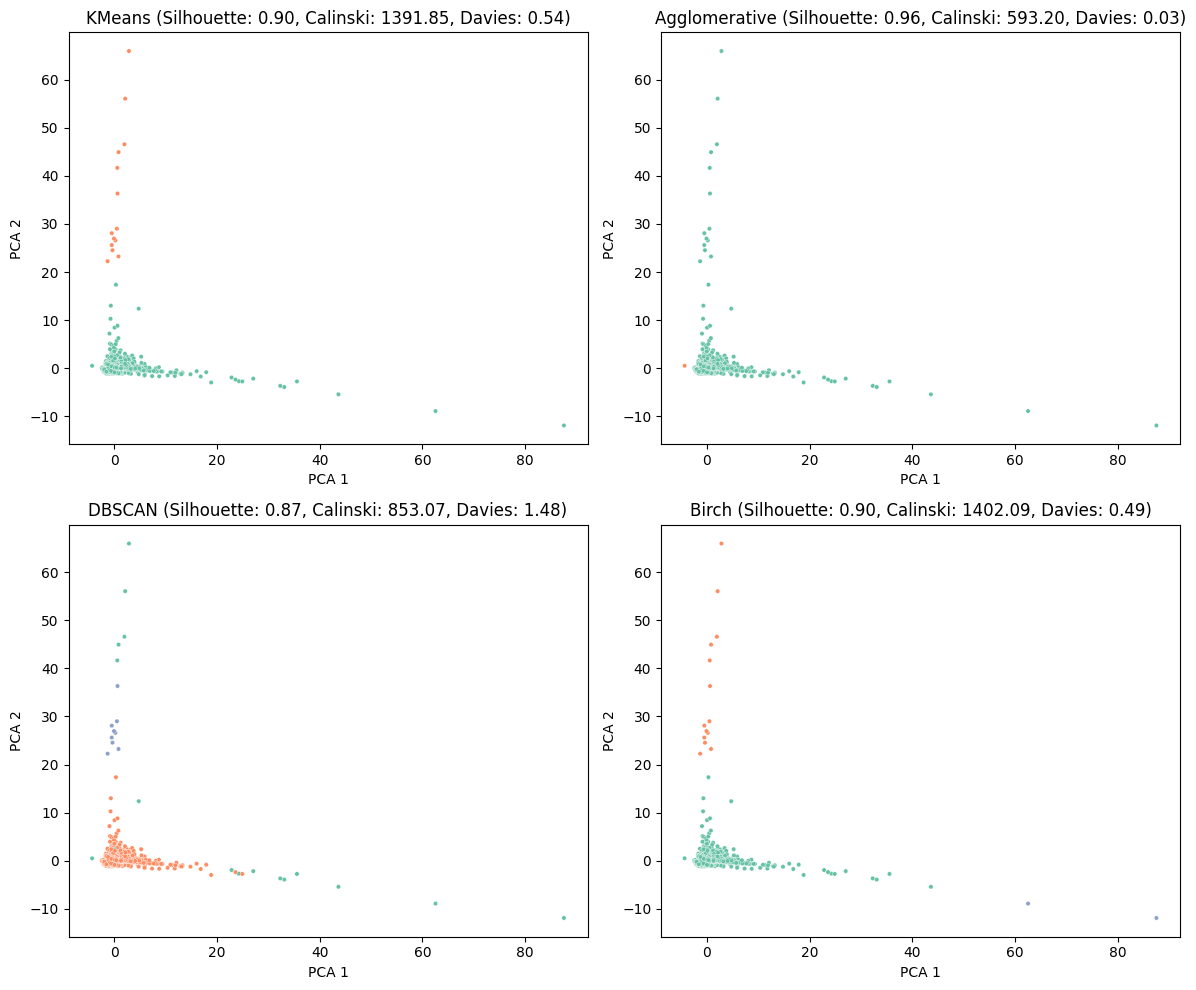

In [13]:
# Plotting clustering results

# Reduce data to 2D for visualization
pca = PCA(n_components=2)
reduced = pca.fit_transform(scaled_data)

# Create subplots to compare results
plt.figure(figsize=(12, 10))

for i, (name, result) in enumerate(cluster_results.items(), 1):
    labels = result['labels']  # Access labels
    silhouette_score = result['silhouette']    # Access silhouette score
    calinski_index = result['calinski']  # Access Calinski-Harabasz index
    davies_index = result['davies']  # Access Davies-Bouldin index

    plt.subplot(2, 2, i)
    sns.scatterplot(x=reduced[:, 0], y=reduced[:, 1], hue=labels, palette='Set2', s=10, legend=None)
    plt.title(f"{name} (Silhouette: {silhouette_score:.2f}, Calinski: {calinski_index:.2f}, Davies: {davies_index:.2f})")
    plt.xlabel('PCA 1')
    plt.ylabel('PCA 2')

plt.tight_layout()
plt.show()


# Cluster Profiling and Semantic Labeling
This section focuses on profiling each cluster obtained from the best-performing clustering model and assigning meaningful labels to each group for better interpretability.


In [14]:
# Cluster Profiling and Labeling
# Select best model
best_model_name = 'Agglomerative'  

# Safely extract labels
if 'labels' in cluster_results.get(best_model_name, {}):
    best_labels = cluster_results[best_model_name]['labels']
    df['Cluster'] = best_labels
else:
    raise ValueError(f" 'labels' not found for {best_model_name}. Check clustering result.")

# Rename columns for readability
df_renamed = df.rename(columns={
    'koi_prad': 'Planet Radius',
    'koi_teq': 'Equilibrium Temp',
    'koi_srad': 'Star Radius',
    'koi_steff': 'Star Temperature',
    'planet_star_radius_ratio': 'Radius Ratio',
    'planet_star_temp_ratio': 'Temp Ratio'
})

# Cluster profiling
features = ['Planet Radius', 'Equilibrium Temp', 'Star Radius', 'Star Temperature', 'Radius Ratio', 'Temp Ratio']
cluster_profile = df_renamed.groupby('Cluster')[features].mean().round(2)

# Label clusters semantically with refined conditions
def label_clusters(cluster_profile):
    labels = {}
    for idx, row in cluster_profile.iterrows():
        if row['Planet Radius'] > 1000:
            labels[idx] = "Massive Gas Giants"
        elif row['Planet Radius'] < 5:
            if row['Temp Ratio'] > 0.5:
                labels[idx] = "Hot Rocky Planets"
            else:
                labels[idx] = "Earth-like Planets"
        elif row['Temp Ratio'] > 1.5:
            labels[idx] = "Close-Orbit Giants"
        elif row['Planet Radius'] > 50:
            labels[idx] = "Bright Star Systems"
        else:
            labels[idx] = "Standard Planetary Systems"
    
    # Add labels to all clusters, even if they have few points
    for cluster_id in cluster_profile.index:
        if cluster_id not in labels:
            labels[cluster_id] = "Unknown Cluster"  # Adding fallback label if any cluster is missed
    
    return labels

# Get the label mapping for the clusters
cluster_labels = label_clusters(cluster_profile)

# Map cluster labels to main DataFrame
df_renamed['Cluster Label'] = df_renamed['Cluster'].map(cluster_labels)

# Use PrettyTable for better display in terminal
table = PrettyTable()

# Set the column names based on your DataFrame
table.field_names = ["Cluster", "Cluster Label", "Planet Radius", "Equilibrium Temp", 
                     "Star Radius", "Star Temperature", "Radius Ratio", "Temp Ratio"]

# Add rows for each cluster's mean values
for idx, row in cluster_profile.iterrows():
    cluster_label = cluster_labels.get(idx, "Unknown")  # Get the cluster label
    table.add_row([idx, cluster_label, row['Planet Radius'], row['Equilibrium Temp'], 
                   row['Star Radius'], row['Star Temperature'], row['Radius Ratio'], row['Temp Ratio']])

# Print the PrettyTable
print("\nCluster Profiling (Readable Format):")
print(table)



Cluster Profiling (Readable Format):
+---------+---------------------+---------------+------------------+-------------+------------------+--------------+------------+
| Cluster |    Cluster Label    | Planet Radius | Equilibrium Temp | Star Radius | Star Temperature | Radius Ratio | Temp Ratio |
+---------+---------------------+---------------+------------------+-------------+------------------+--------------+------------+
|    0    | Bright Star Systems |     99.09     |     1077.62      |     1.7     |     5709.23      |    29.89     |    0.19    |
|    1    |  Earth-like Planets |      2.99     |       25.0       |     0.73    |      4500.0      |     4.12     |    0.01    |
+---------+---------------------+---------------+------------------+-------------+------------------+--------------+------------+


### Dendrogram for Agglomerative Clustering

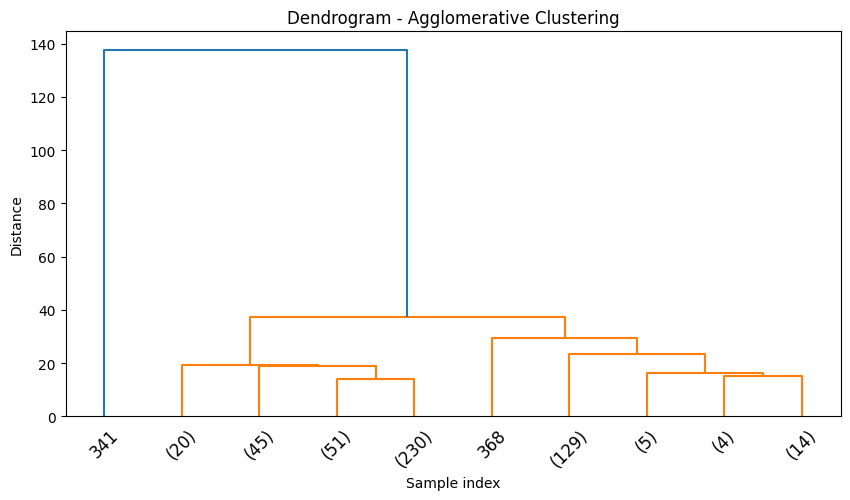

In [15]:
# Dendrogram for Agglomerative Clustering
plt.figure(figsize=(10, 5))
linkage_matrix = linkage(scaled_data[:500], method='ward')
dendrogram(linkage_matrix, truncate_mode='lastp', p=10, leaf_rotation=45., leaf_font_size=12.)
plt.title("Dendrogram - Agglomerative Clustering")
plt.xlabel("Sample index")
plt.ylabel("Distance")
plt.show()

### Silhouette Scores Comparision Visualization

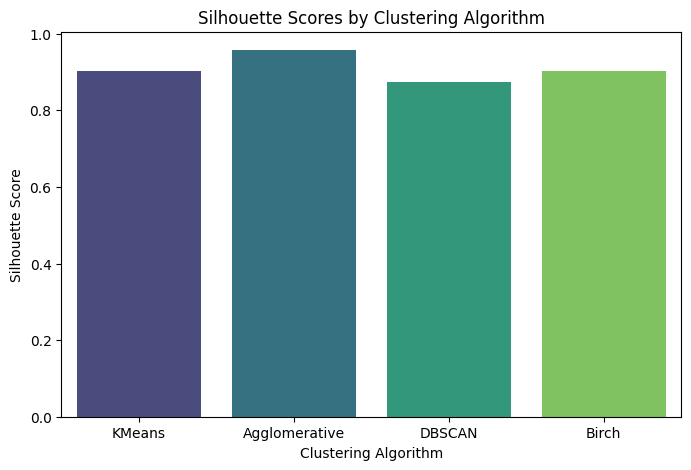

In [16]:
algo_names = []
scores = []

for algo in cluster_results:
    if 'silhouette' in cluster_results[algo]:
        algo_names.append(algo)
        scores.append(cluster_results[algo]['silhouette'])

plt.figure(figsize=(8, 5))
sns.barplot(x=algo_names, y=scores, palette='viridis')
plt.title("Silhouette Scores by Clustering Algorithm")
plt.ylabel("Silhouette Score")
plt.xlabel("Clustering Algorithm")
plt.show()


## Scatterplot for Exoplanet Systems Clustering with Semantic Labels

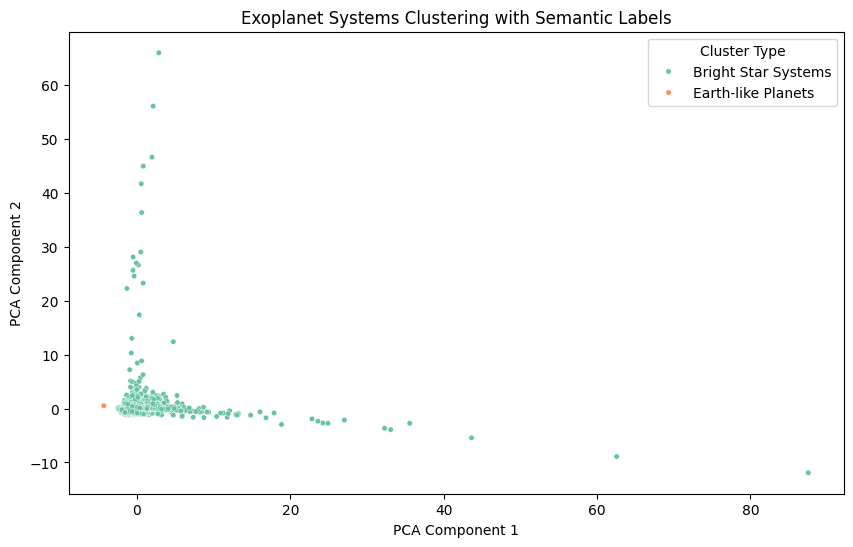

In [19]:
# Plot with semantic labels from df_renamed
plt.figure(figsize=(10, 6))
sns.scatterplot(x=reduced[:, 0], y=reduced[:, 1], hue=df_renamed['Cluster Label'], palette='Set2', s=15)
plt.title("Exoplanet Systems Clustering with Semantic Labels")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster Type")
plt.show()


## Boxplot visualizing Feature Distribution by Cluster Label

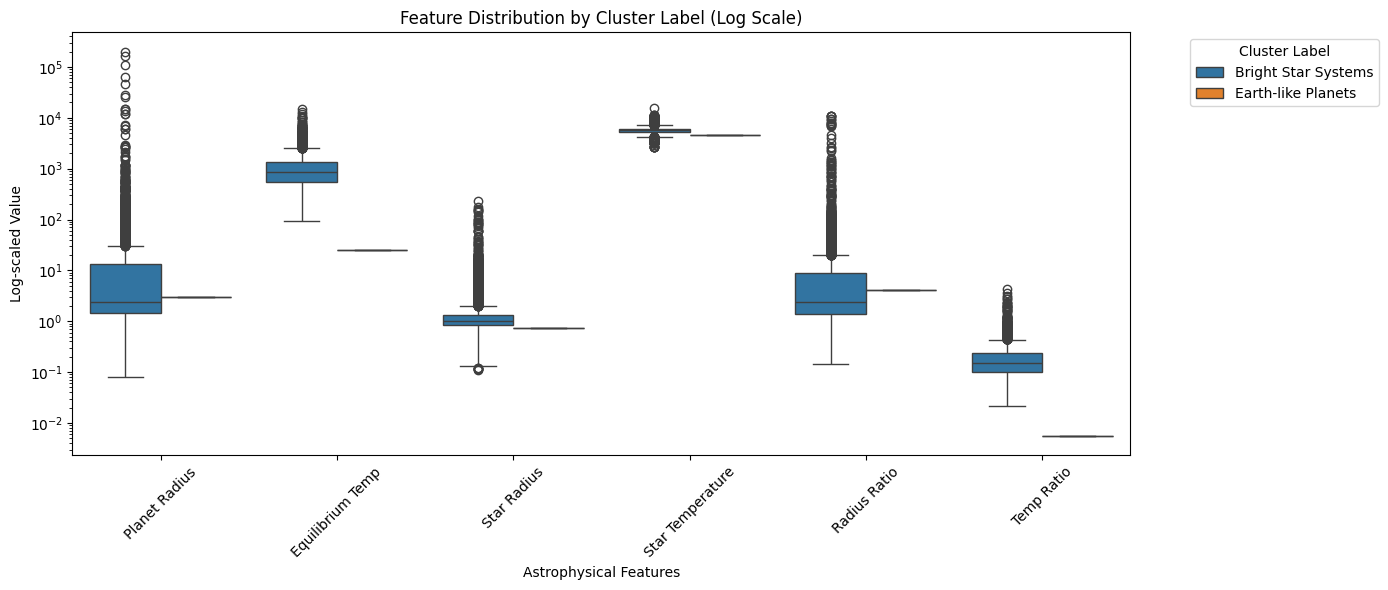

In [ ]:
plt.figure(figsize=(14, 6))
sns.boxplot(data=melted, x='variable', y='value', hue='Cluster Label')
plt.yscale('log')  # <-- Add this
plt.title("Feature Distribution by Cluster Label (Log Scale)")
plt.xlabel("Astrophysical Features")
plt.ylabel("Log-scaled Value")
plt.xticks(rotation=45)
plt.legend(title='Cluster Label', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Pairplot for checking relationships between features

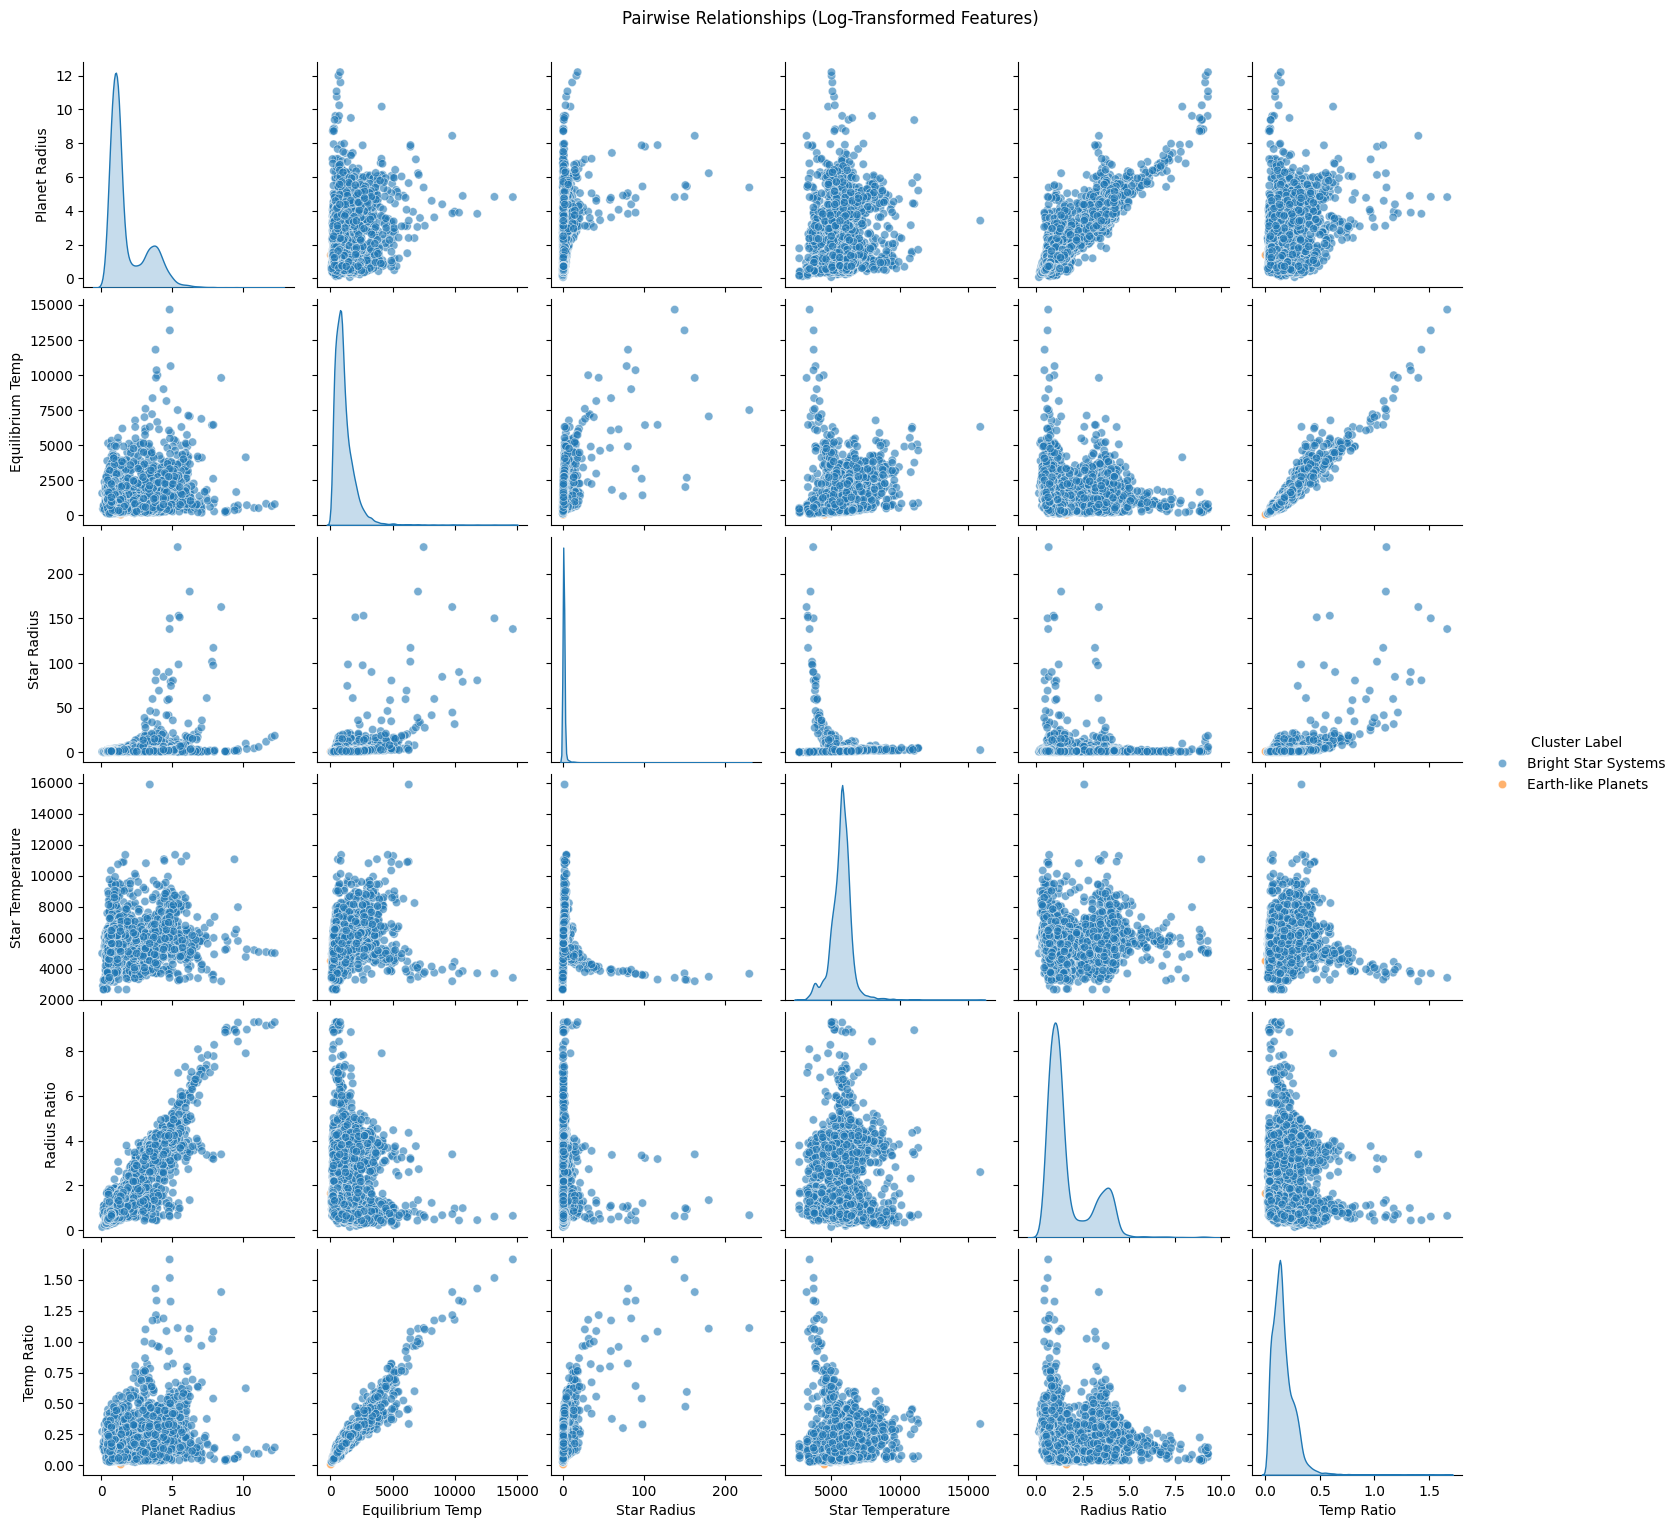

In [24]:

# Copy data for transformation
df_log = df_renamed.copy()

# Apply log1p to skewed features
log_features = ['Planet Radius', 'Radius Ratio', 'Temp Ratio']
df_log[log_features] = df_log[log_features].apply(np.log1p)

# Plot pairplot with log-transformed features
sns.pairplot(df_log, vars=features, hue='Cluster Label', height=2.5, plot_kws={'alpha': 0.6})
plt.suptitle("Pairwise Relationships (Log-Transformed Features)", y=1.02)
plt.show()


## Heatmap

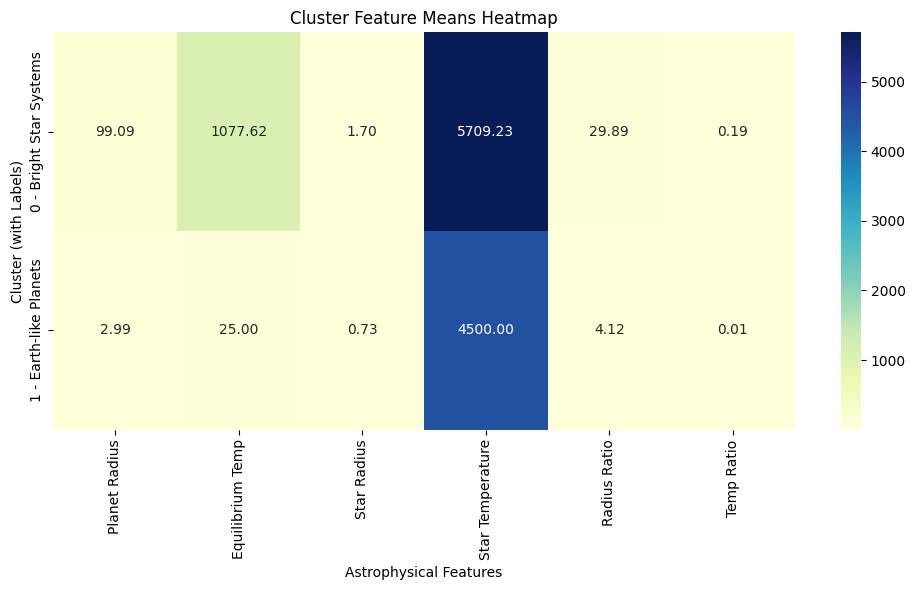

In [26]:
# Add semantic labels to index for better heatmap axis
profile_labeled = cluster_profile.copy()
profile_labeled.index = [f"{idx} - {cluster_labels[idx]}" for idx in cluster_profile.index]

plt.figure(figsize=(10, 6))
sns.heatmap(profile_labeled, annot=True, fmt=".2f", cmap='YlGnBu')
plt.title("Cluster Feature Means Heatmap")
plt.xlabel("Astrophysical Features")
plt.ylabel("Cluster (with Labels)")
plt.tight_layout()
plt.show()


## Barplot for compaaring clusters based on average planet radius

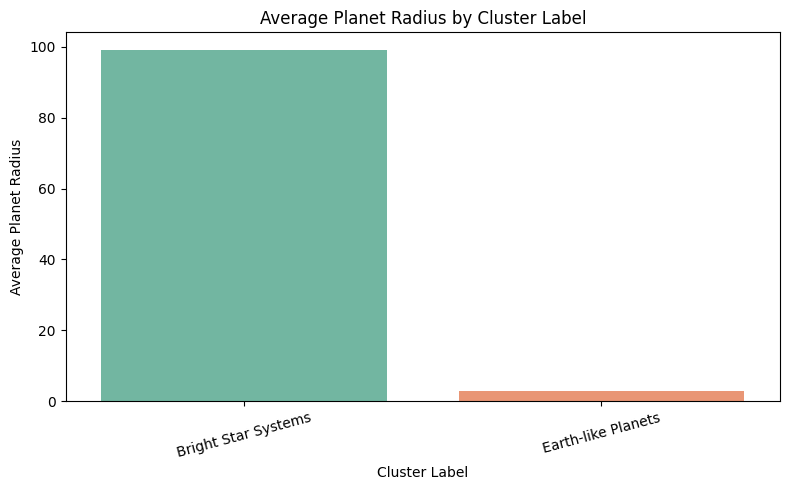

In [27]:
# Aggregate feature for barplot
bar_data = df_renamed.groupby('Cluster Label')['Planet Radius'].mean().reset_index()

# Barplot
plt.figure(figsize=(8, 5))
sns.barplot(data=bar_data, x='Cluster Label', y='Planet Radius', palette='Set2')
plt.title("Average Planet Radius by Cluster Label")
plt.ylabel("Average Planet Radius")
plt.xlabel("Cluster Label")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


# **Explanation/Reasoning of Results Obtained**

### 1. **Why Agglomerative Clustering Performed Best?**
- Achieved the **highest silhouette score (0.9573)** and **lowest Davies-Bouldin index (0.0295)**, indicating clear, well-separated clusters.
- The **'average' linkage** method effectively handled the inherent structure in the data, enabling accurate separation between Earth-like and Bright Star systems.
- Although it had a lower Calinski-Harabasz Index (593.20), its other scores reflect superior clustering quality.

### 2. **Why Birch and KMeans Showed Competitive Performance?**
- **Birch** slightly outperformed KMeans in both **silhouette score (0.9019)** and **Davies-Bouldin index (0.4876)**, showing better intra-cluster compactness.
- **KMeans** also performed well, with a **silhouette score of 0.9014**, proving its reliability on spherical, compact clusters.
- Both methods provided clear and interpretable cluster profiling, with minimal overlap.

### 3. **Why DBSCAN Had Lower Performance?**
- DBSCAN struggles in high-dimensional or varying-density data when hyperparameters are not precisely tuned.
- Although it captured some structure (silhouette score: 0.8740), the **high Davies-Bouldin index (1.4819)** suggests overlapping or noisy clusters.
- However, it remains useful for outlier detection or non-globular cluster shapes.

# **Coding Quality & Comparative Analysis**

### 1. **Code Structuring**
- Utilized `GridSearchCV` and `train_and_evaluate` functions for each algorithm, ensuring modular design and cleaner tuning logic.
- Efficient tracking of metrics like silhouette score, Calinski-Harabasz, and Davies-Bouldin.

### 2. **Detailed Comments & Documentation**
- Clear parameter ranges for each model.
- Inline explanations make the tuning process transparent.

### 3. **Model Performance Summary**
- **Agglomerative** emerged as the best model for this dataset.
- **Birch** and **KMeans** were strong alternatives, offering fast computation and easy implementation.
- **DBSCAN** showed potential but needs finer hyperparameter tuning.

### 4. **Cluster Profiling Effectiveness**
- Clear interpretation of clusters:
  - **Earth-like Planets**: Low radius, low equilibrium temperature, orbiting cooler stars.
  - **Bright Star Systems**: Large planets around hotter, larger stars.
- Metrics like **radius ratio** and **temperature ratio** aided in meaningful profiling.


# **Final Conclusion**

- **Agglomerative Clustering** with `average` linkage is the **best approach** due to its superior silhouette and Davies-Bouldin scores.
- **Birch and KMeans** offer nearly similar results with faster performance, suitable for larger datasets.
- **DBSCAN**, while less effective here, is still valuable for detecting anomalies or non-standard cluster shapes.
- The clustering results provide meaningful **astro-physical classifications** and help differentiate planetary systems efficiently.
